In [1]:
from scipy import stats
from sklearn import tree
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px
from PIL import Image
from IPython.display import display


In [2]:
sport_eve = pd.read_stata("dati/td_ita.dta")
sport_eve = sport_eve[sport_eve['first2w'].isin(['First two weeks'])]
sport_eve = sport_eve[['id', 'date_not','what', 'withw', 'where']]
sport_eve.id = sport_eve.id.astype(int)
sport_eve['date_not'] = pd.to_datetime(sport_eve['date_not'])

In [3]:
# Building a way to check from code what weekday it was and storing weekends 
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0, 7):
    dictdays[i] = weekdays[i]

#list of weekend days in calendar time
weekend_clock_days = [14, 15, 21, 22, 28]

for day in weekend_clock_days:
    weekday = weekdays[sport_eve[sport_eve.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")

The date 14 was a Sat
The date 15 was a Sun
The date 21 was a Sat
The date 22 was a Sun
The date 28 was a Sat


In [4]:
sport_eve

,id,date_not,what,withw,where
0,0,2020-11-13 00:00:00,No information,No information,No information
1,0,2020-11-13 00:30:00,No information,No information,No information
2,0,2020-11-13 01:00:00,No information,No information,No information
3,0,2020-11-13 01:30:00,No information,No information,No information
4,0,2020-11-13 02:00:00,No information,No information,No information
...,...,...,...,...,...
268205,266,2020-11-30 19:00:00,Study/work group,Alone,Home apartment /room
268206,266,2020-11-30 20:00:00,"Cooking, Food preparation & management",Alone,Home apartment /room
268207,266,2020-11-30 21:00:00,"Cooking, Food preparation & management",Alone,Home apartment /room
268208,266,2020-11-30 22:00:00,Eating,Alone,Home apartment /room


# Filling in the missing, inactive status data

In [5]:
def today_or_yesterday(t): 
    if t.hour < 5:
        return days[t.day - 1]
    else:
        return days[t.day]

days = dict()
for i in range(sport_eve.date_not.dt.day.min(), sport_eve.date_not.dt.day.max() + 2 ):
    days[i-1] = i - sport_eve.date_not.dt.day.min()  

min_range = pd.date_range(start="2020-11-13 00:00:00", end="2020-11-30 23:59:59", freq='30T')
results = pd.DataFrame()
for user in tqdm(sport_eve.id.unique()):
    subset = sport_eve[sport_eve.id == user]
    complete_data = pd.DataFrame({'date_not': min_range})
    merged_df = pd.concat([complete_data, subset])
    merged_df['id'] = merged_df['id'].fillna(user)
    
    merged_df = merged_df.sort_values(by="what", na_position='first', ascending=False).drop_duplicates(keep='last', subset='date_not')
    
    merged_df['what'] = merged_df['what'].astype(str)
    merged_df['what'] = merged_df['what'].replace("nan", "Inactive")
    
    if merged_df.date_not.min() != complete_data.date_not.min() or merged_df.date_not.max() != complete_data.date_not.max():
        print()
        print(f"Some mistake occurred. \nThe amount of observation time is different than expected.\nUser: {user}, dates: {merged_df.date_not.min(), merged_df.date_not.max()}")
        print()
    if merged_df.shape[0] != complete_data.shape[0]: 
        print()
        print(f"Some mistake occurred. \nThe amount rows is different than expected.\nUser: {user}, length: {merged_df.shape[0]}, expected: {complete_data.shape[0]}")
        print()
    
    results = pd.concat([results, merged_df], ignore_index=True)
results['day'] = [today_or_yesterday(time) for time in results.date_not]
results.id = results.id.astype(int)

100%|█████████████████████████████████████████| 241/241 [00:03<00:00, 77.08it/s]


In [6]:
results.shape[0] #final result
complete_data.shape[0]*len(sport_eve.id.unique())   #total time any user has available during the experiment x n users
sport_eve.shape[0] #total each user had walked and did sports x n users
results.shape[0] - complete_data.shape[0]*len(sport_eve.id.unique())

# CHECK: EVERY HOUR (in a 24 day representing all the observation time) SHOULD HAVE THE SAME LENGTH.
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
experiment = results
experiment['hour'] = experiment['date_not'].dt.hour - 5
experiment['hour'] = [today_or_yesterday(hour) for hour in experiment['hour']]

total = []
for hour in experiment['hour'].unique():
    total.append(sum(experiment[experiment['hour']==hour][['what']].value_counts().sort_values()))
print(total)    

[8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676]


In [7]:
results

,date_not,id,what,withw,where,day,hour
0,2020-11-30 10:30:00,0,Inactive,NaN,NaN,18,5
1,2020-11-30 11:30:00,0,Inactive,NaN,NaN,18,6
2,2020-11-30 12:30:00,0,Inactive,NaN,NaN,18,7
3,2020-11-30 13:30:00,0,Inactive,NaN,NaN,18,8
4,2020-11-30 14:30:00,0,Inactive,NaN,NaN,18,9
...,...,...,...,...,...,...,...
208219,2020-11-13 15:00:00,266,Sleeping,Alone,Home apartment /room,1,10
208220,2020-11-13 14:30:00,266,Sleeping,Alone,Home apartment /room,1,9
208221,2020-11-13 14:00:00,266,Sleeping,Alone,Home apartment /room,1,9
208222,2020-11-13 13:30:00,266,Sleeping,Alone,Home apartment /room,1,8


In [8]:
results[(results.id == 77) & (results.date_not >= "2020-11-25 22:00:00") &
          (results.date_not <= "2020-11-26 08:30:00")].sort_values(by='date_not').head(8)
#omg it worked

,date_not,id,what,withw,where,day,hour
60824,2020-11-25 22:00:00,77,"In chat on Internet or reading, sending e-mail",Alone,Home apartment /room,13,17
60754,2020-11-25 22:30:00,77,"Watching TV, video, YouTube, etc.",Alone,Home apartment /room,13,17
60709,2020-11-25 23:00:00,77,Sport,Alone,Home apartment /room,13,18
60716,2020-11-25 23:30:00,77,Sport,Alone,Home apartment /room,13,18
60723,2020-11-26 00:00:00,77,Sport,Alone,Home apartment /room,13,19
60756,2020-11-26 00:30:00,77,"Watching TV, video, YouTube, etc.",Alone,Home apartment /room,13,19
60607,2020-11-26 01:00:00,77,No information,No information,No information,13,20
60608,2020-11-26 01:30:00,77,No information,No information,No information,13,20


In [9]:
results.day.unique()

array([18,  0,  3,  7,  4, 12, 11,  9,  5,  6,  1, 13, 16,  2, 15, 17,  8,
       14, 10])

# By hour (all days in one), sport sessions. All 197 users.

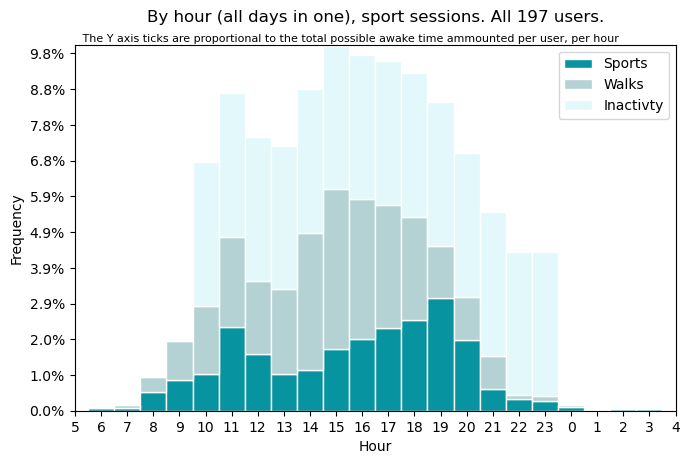

In [10]:
g = results
g['hour'] = g['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks', 'Inactivty'],
        color=("#0893a1", "#b4d1d4", "#e3f8fa")
       )

N = results[results['hour'] == 0].shape[0] - results[results['hour'] == 0].shape[0] * 7/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'By hour (all days in one), sport sessions. All 197 users.', y=1.04)
plt.suptitle("   The Y axis ticks are proportional to the total possible awake time ammounted per user, per hour", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byhour_everyday.png')

plt.show()

# By experiment day, all 197 users 

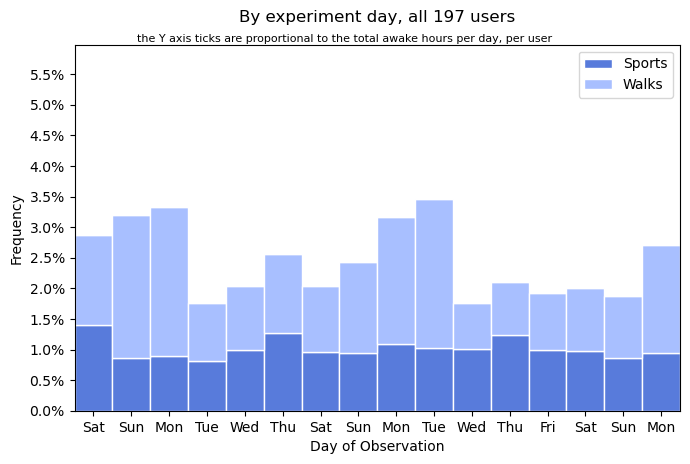

In [11]:
g = results[results.day != 0]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

ax.hist([g['day'][g['what'] == 'Sport'], g['day'][g['what'] == "Walking"], g['day'][g['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(g.day.unique()) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#587bdb", "#a8bfff", "#e3e9fa")
       )

N = results[results['hour'] == 0].shape[0] - results[results['day'] == 0].shape[0] * 7/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
list_of_days = ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu']*2
list_of_days.extend(['Fri', 'Sat', 'Sun', 'Mon', 'Tue'])
plt.xticks(np.arange(1, len(g.day.unique())), list_of_days)
plt.xlabel('Day of Observation')
plt.ylabel('Frequency')
plt.ylim(0, 0.06*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.xlim(0.5,16.5)
#plt.margins(x=-0.01)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'By experiment day, all 197 users', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total awake hours per day, per user", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byexperimentday_everyday.png')

plt.show()

# Lecture days (Monday to Friday) only, all 197 users

/tmp/ipykernel_5924/1123676736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['hour'] = g1['date_not'].dt.hour - 5
/tmp/ipykernel_5924/1123676736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['hour'] = [today_or_yesterday(hour) for hour in g1['hour']]


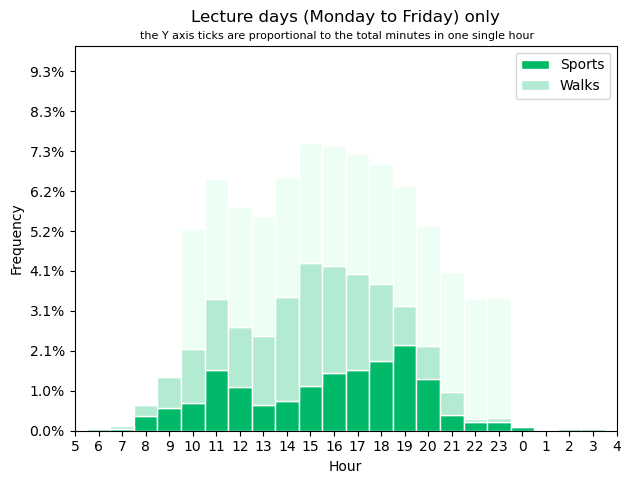

In [12]:
g1 = results[~results.day.isin(weekend_clock_days)]

g1['hour'] = g1['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g1['hour'] = [today_or_yesterday(hour) for hour in g1['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#00ba69", "#b2ebd2", "#edfff4")
       )
       
N = g1[g1.hour==0].shape[0]
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

plt.title(f'Lecture days (Monday to Friday) only', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('lecturedays.png')

plt.show()

# Weekends only, all 197 users

/tmp/ipykernel_5924/3490103821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['hour'] = g2['date_not'].dt.hour - 5
/tmp/ipykernel_5924/3490103821.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['hour'] = [today_or_yesterday(hour) for hour in g2['hour']]


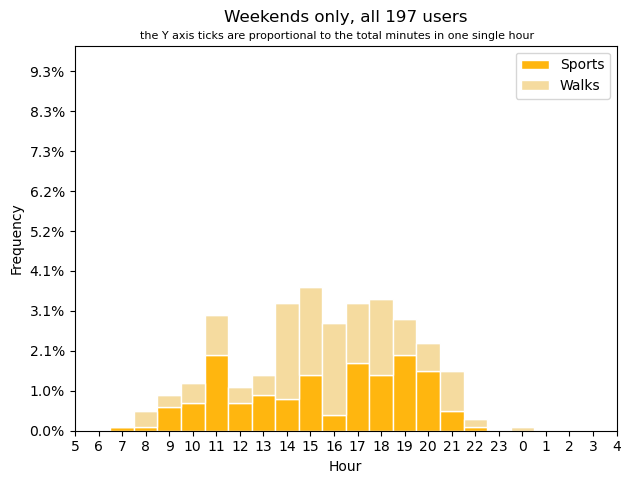

In [13]:
g2 = results[results.day.isin(weekend_clock_days)]

g2['hour'] = g2['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g2['hour'] = [today_or_yesterday(hour) for hour in g2['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#ffb60f", "#f5db9f", "#fff8e8")
       )
       
N = g2[g2.hour == 0].shape[0]
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

plt.title(f'Weekends only, all 197 users', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('weekends.png')

plt.show()

<module 'matplotlib.pyplot' from '/home/fluve/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

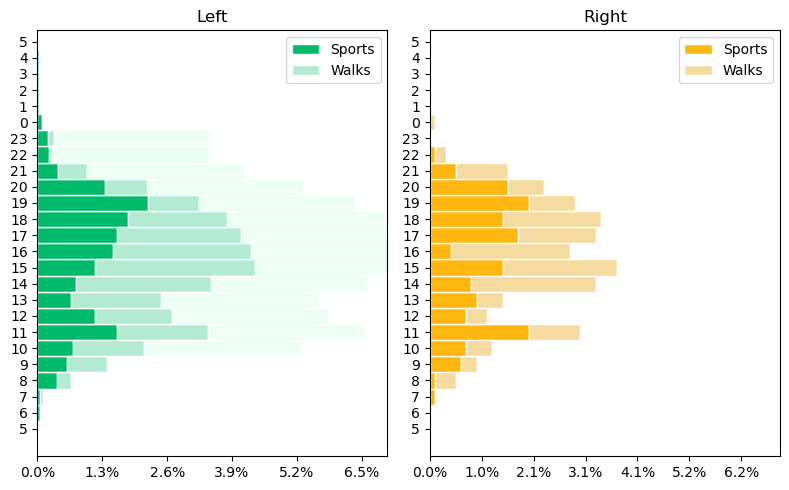

In [14]:
import matplotlib.pyplot as plt
import numpy as np

values1, values2 = [g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']], [g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']]

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 2, 1)  # 2 rows, 1 column, first subplot
ax1.hist(values1,
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         stacked=True,
         edgecolor='white', label=['Sports', 'Walks'],
         color=("#00ba69", "#b2ebd2", "#edfff4"),
         orientation = "horizontal")
N1 = g1[g1['hour'] == 0].shape[0]
ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N1, decimals=1))
ax1.set_title('Left')
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.xlim(0, 0.07*N1)
plt.legend()

# Second subplot
ax2 = fig.add_subplot(1, 2, 2)  # 2 rows, 1 column, second subplot
ax2.hist(values2,
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         stacked=True, edgecolor='white', label=['Sports', 'Walks'],
         color=("#ffb60f", "#f5db9f", "#fff8e8"),
         orientation = "horizontal")
N2 = g2[g2['hour'] == 0].shape[0]
ax2.xaxis.set_major_formatter(PercentFormatter(xmax=N2, decimals=1))
plt.yticks(np.arange(len(custom_order)), custom_order)
ax2.set_title('Right')
plt.xlim(0, 0.07*N2)
plt.legend()

plt.tight_layout()
plt

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]


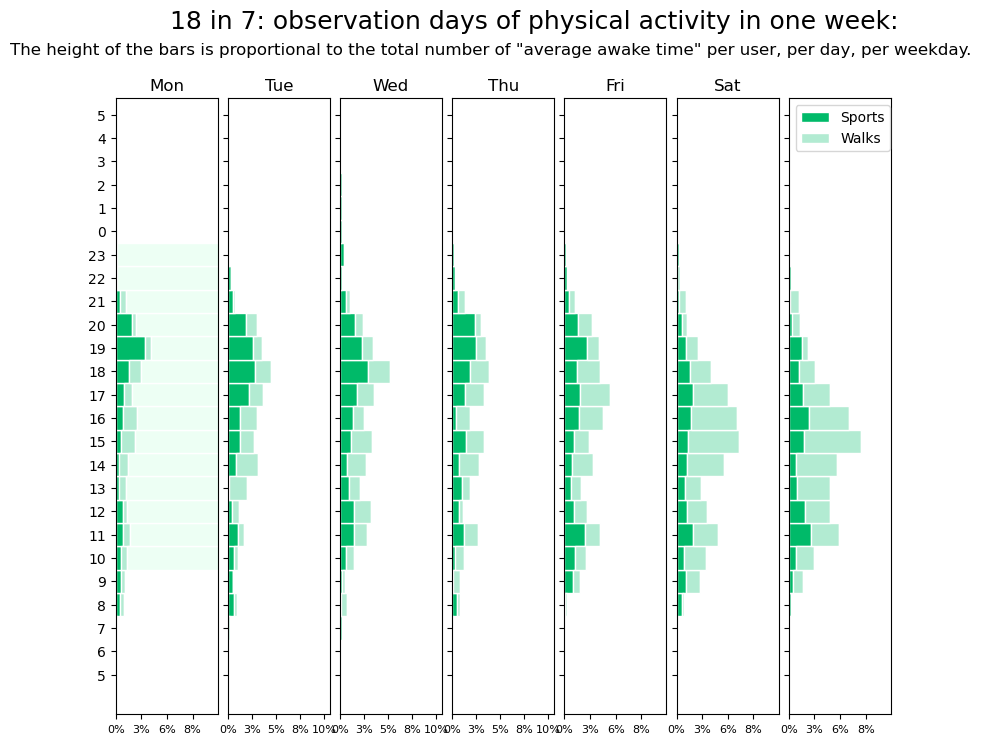

In [15]:
#For every day of the experiment, make one histogram. 
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']]
    ax1 = axs[current_day]
    ax1.hist(values,
             bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
             stacked=True,edgecolor='white', label=['Sports', 'Walks'],
             color=("#00ba69", "#b2ebd2", "#edfff4"),
             orientation = "horizontal")
    ax1.set_xticks([])
    N = g[g['hour'] == 0].shape[0]
    ax1.set_xlim([0, 0.11*N])
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))
    ax1.set_title(f'{weekdays[current_day]}')    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=8)
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    #.margins(y=-0.02)
    
    
fig.subplots_adjust(wspace=0.1)   
plt.suptitle('The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.', y=0.95)
plt.title("18 in 7: observation days of physical activity in one week:", fontsize=18, y=1.1 , x=-2.5)
plt.legend()
plt.savefig('a_typical_week.png')
plt.show()


# Breaking time down by sociodemographic factors.
From Maja's script, use sport.analysis.ipynb. Import Location, type of activity, company, start_time, end_time

In [16]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

In [17]:
td_dataset = pd.read_stata("dati/td_ita.dta")  # time diaries dataset
demo_dataset = pd.read_stata("dati/data4diarynew_ITA.dta") # demographics dataset
step_dataset = pd.read_csv("dati/stepDetector_30min.csv") # step counter dataset

Cleaning procedure of the time diaries dataset.
We need to apply two steps:

   - consider only first two weeks of the survey
   - consider only the answers in which the users declared they are were doing any kind of sport activity

In [18]:
td_cleaned = td_dataset[td_dataset['first2w'] == 'First two weeks']
#td_cleaned = td_cleaned[(td_cleaned["what"]=="Sport") | (td_cleaned["what"]=="I will participate in sports activities") |(td_cleaned["what"]=="Walking")]

Variable transformation

New variables we want to analyze are:
- the duration of the sport activity
- the location of the sport activity considering if the users is in 'private' space (indoor) or in public space (outdoor)
- with who the user is practicing sport: if alone or in company
- the type of sport activity the user is practicing


In [19]:
# duration of sport activity variable
new_td = td_cleaned
new_td['date_not'] = pd.to_datetime(new_td['date_not'])
new_td['date_dur'] = new_td['date_not'] - timedelta(hours = 5)

new_td = new_td .sort_values('date_dur') # sort the dataframe according to "date_dur"
new_td['time_diff'] = new_td['date_dur'].diff() # compute the time difference between adjacent rows

new_session = (new_td['time_diff'] > pd.Timedelta(minutes=30)) | new_td['time_diff'].isnull() # search for new start session
new_td['session'] = new_session.cumsum() # Creazione di un nuovo identificatore di sessione basato su new_session

collapsed_sessions = new_td.groupby(['id', 'session']).agg(
    start_time=('date_not', 'first'),
    end_time=('date_not', 'last'),
    duration=('date_dur', lambda x: ((x.max() - x.min()).total_seconds() / 60)+30)
).reset_index()

collapsed_sessions = collapsed_sessions.drop(columns='session')

# merge the two datasets
td_cleaned = td_cleaned.merge(collapsed_sessions, left_on=['id', 'date_not'], right_on=['id', 'start_time']) # inner join of the two datasets


/tmp/ipykernel_5924/2576700087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_td['date_not'] = pd.to_datetime(new_td['date_not'])
/tmp/ipykernel_5924/2576700087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_td['date_dur'] = new_td['date_not'] - timedelta(hours = 5)


# Data cleaning

After computing the duration of the sport session we need to apply two more data cleaning criteria:
1. we want to eliminate the sport session in which the type of sport is Walking and the duration is 30 minutes or less, because we cannot guarantee that the user is doing sport but likely they are just commuting to go somewhere.
2. we want also to eliminate the sport sessions in which the type of sport is Walking and the location is the university or grocery shops. In such cases the probability that the user is just walking is higher than the probability that the user is doing sport nearby these places.

In [20]:
# obtain the indexes of the rows satisfying condition 1
to_remove1 = list(td_cleaned[(td_cleaned['what']=='Walking') & (td_cleaned['duration']==30.0)].index)
print(td_cleaned.shape)
# remove these cases
td_cleaned = td_cleaned.drop(index=to_remove1)
print(td_cleaned.shape)
# obtain the indexes of the rows satisfying condition 2
places = [ 'Supermarket …', 'Street markets', 'Grocery Shop', 'University Library', 'Other university place']
to_remove2 = list(td_cleaned[(td_cleaned['what']=='Walking') & (td_cleaned['where'].isin(places))].index)

# remove these cases
td_cleaned = td_cleaned.drop(index=to_remove2)
print(td_cleaned.shape)

(1325, 105)
(1044, 105)
(1033, 105)

# location of sport activity variable
td_cleaned['where recoded'] = td_cleaned['where'].replace(['Home apartment /room', 'Weekend home or holiday apartment', 'House (friends others)', 'Relatives Home', 'Home garden/patio/courtyard',
                                                           'Another indoor place', 'Gym, swimming pool, Sports centre …', 'Other university place', 'Countryside/mountain/hill/beach', 'In the street', 'Another outdoor place', 'Café, pub, bar', 'Shops, shopping centres', 'Not answer'],
                                                          ['indoor', 'indoor', 'indoor', 'indoor', 'indoor',
                                                           'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'not specified'])
td_cleaned['where recoded'] = td_cleaned['where recoded'].cat.remove_unused_categories()

# company during sport activity variable
td_cleaned['withw recoded'] = td_cleaned['withw'].replace(['Partner', 'Friend(s)', 'Relative(s)', 'Roommate(s)', 'Other', 'Colleague(s)',
                                                           'Classmate(s)',
                                                           'Alone',
                                                           'Not answer'],
                                                          ['company', 'company', 'company', 'company', 'company', 'company', 'company',
                                                           'alone',
                                                           'not specified'])

td_cleaned['withw recoded'] = td_cleaned['withw recoded'].cat.remove_unused_categories()

# type of sport activity variable
td_cleaned['sport recoded'] = td_cleaned['sport'].replace(['Walking, Trekking, and hiking',
                                                           'Jogging and running',
                                                           'Cycling, skiing, and skating', 'Ball games', 'Other outdoor activities',
                                                           'Gymnastics and fitness',
                                                           'Water sports', 'Other indoor activities'
                                                           ],
                                                          ['Walking, Trekking, and hiking',
                                                           'Jogging and running',
                                                           'Outdoor activities', 'Outdoor activities', 'Outdoor activities',
                                                           'Gymnastics and fitness',
                                                           'Other indoor activities', 'Other indoor activities'
                                                           ])

# adding the category Walking to the sport activity
td_cleaned['sport recoded'] = td_cleaned['sport recoded'].cat.add_categories('Walking')
td_cleaned.loc[td_cleaned['what'] == 'Walking', 'sport recoded'] = 'Walking'

td_cleaned['sport recoded'] = td_cleaned['sport recoded'].cat.remove_unused_categories()

# useful conversions
td_cleaned['id'] = td_cleaned['id'].astype(int)
demo_dataset['userid'] = demo_dataset['userid'].astype(int)
td_cleaned['hours'] = td_cleaned['date_not'].dt.hour

new_dataset = td_cleaned.copy()
new_dataset = new_dataset[['id', 'start_time', 'week', 'DD_not', 'hh_not', 'sport recoded', 'duration', 'where recoded', 'withw recoded', 'date_not']]
cat_dataset = new_dataset.merge(demo_dataset, left_on='id', right_on='userid', how='left')

cat_dataset = cat_dataset[[ 'id', 'duration','sport recoded', 'where recoded', 'withw recoded','degree', 'department', 'w1_A01', 'date_not']]
cat_dataset.columns = ['id', 'duration', 'type of activity', 'location', 'company', 'degree', 'department',  'sex', 'timestamp']

(3374, 105)
(3348, 105)
(3348, 105)


# END OF MAJA's CONTRIBUTION
Back to time visualization, this very useful section serves the purpose to distinguish specific sessions that are legitimately over-the-median physical activity from any kind of bodily movement. In the following sections, I will keep in my time diary only the events that belong to active sport sessions and forget the ones who just represent "short commuting" or "too short sessions" to be considered relevant anyway. 


In [21]:
cat_dataset['type of activity'].unique()

[NaN, 'Gymnastics and fitness', 'Jogging and running', 'Other indoor activities', 'Walking, Trekking, and hiking', 'Outdoor activities']
Categories (5, object): ['Walking, Trekking, and hiking' < 'Jogging and running' < 'Outdoor activities' < 'Gymnastics and fitness' < 'Other indoor activities']

In [22]:
#First thing: remove the users that have no qualified sport sessions 
print(f"Difference in id number from clean to cleaner: {len(sport_eve.id.unique())} - {len(cat_dataset.id.unique())} = {len(sport_eve.id.unique()) - len(cat_dataset.id.unique())}")
to_remove = list(sport_eve[~(sport_eve['id'].isin(cat_dataset.id.unique()))].index)
print(f"Rows:{sport_eve.shape[0]}")
print('removing...')
cl_sport_eve = sport_eve.drop(index=to_remove)
print(f"Rows:{cl_sport_eve.shape[0]}")
print(len(cl_sport_eve.id.unique()))

Difference in id number from clean to cleaner: 241 - 241 = 0
Rows:204850
removing...
Rows:204850
241


In [23]:
# reminder: sport_eve is the dataset from the raw data that has 
# all the events in which users indicated they were walking or doing sports. 
# it does not have the inactive events (that were artificially added as you see in previous sections. 

        #Baby example of what's going on: 

    # for every user, for every observation in the cleaner dataset:
    
user = 9
first = cat_dataset[cat_dataset.id == 9].sort_values(by='timestamp').timestamp.tolist()[0]  #[0] means I only get the first as an example
print(first)
#the end is just the start + duration time so:
duration_in_hours = cat_dataset[cat_dataset.id ==9].sort_values(by='timestamp').duration.tolist()[0] // 60
second = first + timedelta(hours=duration_in_hours, seconds=1)

#window of time for acceptable observations:
range_to_check = pd.date_range(start=first, end=second, freq='30T')

    #for every user, for every observation:
user_data = cl_sport_eve[cl_sport_eve.id == 9].sort_values(by='date_not')

to_keep = user_data.date_not.isin(range_to_check)
user_data[to_keep].head()  #now only outputting the events during a sport session.

# Ta daa! Now I will automate this process.

2020-11-13 00:00:00


,id,date_not,what,withw,where
10026,9,2020-11-13 00:00:00,No information,No information,No information
10027,9,2020-11-13 00:30:00,No information,No information,No information
10028,9,2020-11-13 01:00:00,No information,No information,No information
10029,9,2020-11-13 01:30:00,No information,No information,No information
10030,9,2020-11-13 02:00:00,No information,No information,No information


In [24]:
cat_dataset[cat_dataset.id == 9].sort_values(by='timestamp').timestamp

126   2020-11-13 00:00:00
127   2020-11-30 11:00:00
128   2020-11-30 12:00:00
129   2020-11-30 13:00:00
130   2020-11-30 14:00:00
131   2020-11-30 15:00:00
132   2020-11-30 16:00:00
133   2020-11-30 17:00:00
134   2020-11-30 18:00:00
135   2020-11-30 19:00:00
136   2020-11-30 20:00:00
137   2020-11-30 21:00:00
138   2020-11-30 22:00:00
139   2020-11-30 23:00:00
Name: timestamp, dtype: datetime64[ns]

In [25]:
clean_events = pd.DataFrame()
for user in tqdm(cl_sport_eve.id.unique()):
    first = cat_dataset[cat_dataset.id == user].sort_values(by='timestamp').reset_index().timestamp.tolist()
    duration_in_hours = (cat_dataset[cat_dataset.id == user].sort_values(by='timestamp').duration / 60).tolist()
    second = [first[i] + timedelta(hours=duration_in_hours[i], seconds=1) for i in range(len(duration_in_hours))]
    #first and second are now ready. 
    for i in range(len(first)):
        range_to_check = pd.date_range(start=first[i], end=second[i], freq='30T')
        
        #masking the other, less clean but eventful dataset 
        user_data = cl_sport_eve[cl_sport_eve.id == user].sort_values(by='date_not')
        to_keep = user_data.date_not.isin(range_to_check)
        user_data[to_keep]  
    clean_events = pd.concat([clean_events, user_data], ignore_index=True)    
    

100%|█████████████████████████████████████████| 241/241 [00:09<00:00, 24.52it/s]


In [26]:
clean_events

,id,date_not,what,withw,where
0,0,2020-11-13 00:00:00,No information,No information,No information
1,0,2020-11-13 00:30:00,No information,No information,No information
2,0,2020-11-13 01:00:00,No information,No information,No information
3,0,2020-11-13 01:30:00,No information,No information,No information
4,0,2020-11-13 02:00:00,No information,No information,No information
...,...,...,...,...,...
204845,266,2020-11-30 19:00:00,Study/work group,Alone,Home apartment /room
204846,266,2020-11-30 20:00:00,"Cooking, Food preparation & management",Alone,Home apartment /room
204847,266,2020-11-30 21:00:00,"Cooking, Food preparation & management",Alone,Home apartment /room
204848,266,2020-11-30 22:00:00,Eating,Alone,Home apartment /room


In [27]:
clean_events
#everything you see below was done at the start of this notebook, it's for making
# data more machine - readable
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(0, 7):
    dictdays[i] = weekdays[i]
weekend_clock_days = [14, 15, 21, 22, 28]
print("The weekends:")
for day in weekend_clock_days:
    weekday = weekdays[clean_events[clean_events.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")
def today_or_yesterday(t): 
    if t.hour < 5:
        return days[t.day - 1]
    else:
        return days[t.day]

days = dict()
for i in range(sport_eve.date_not.dt.day.min(), sport_eve.date_not.dt.day.max() + 2 ):
    days[i-1] = i - sport_eve.date_not.dt.day.min()  

min_range = pd.date_range(start="2020-11-13 00:00:00", end="2020-11-30 23:59:59", freq='30T')
results = pd.DataFrame()

for user in clean_events.id.unique():
    subset = clean_events[clean_events.id == user]
    complete_data = pd.DataFrame({'date_not': min_range})
    merged_df = pd.concat([complete_data, subset])
    merged_df['id'] = merged_df['id'].fillna(user)
    
    merged_df = merged_df.sort_values(by="what", na_position='first', ascending=False).drop_duplicates(keep='last', subset='date_not')
    
    merged_df['what'] = merged_df['what'].astype(str)
    merged_df['what'] = merged_df['what'].replace("nan", "Inactive")
    
    if merged_df.date_not.min() != complete_data.date_not.min() or merged_df.date_not.max() != complete_data.date_not.max():
        print()
        print(f"Some mistake occurred. \nThe amount of observation time is different than expected.\nUser: {user}, dates: {merged_df.date_not.min(), merged_df.date_not.max()}")
        print()
    if merged_df.shape[0] != complete_data.shape[0]: 
        print()
        print(f"Some mistake occurred. \nThe amount rows is different than expected.\nUser: {user}, length: {merged_df.shape[0]}, expected: {complete_data.shape[0]}")
        print()
    
    results = pd.concat([results, merged_df], ignore_index=True)
results['day'] = [today_or_yesterday(time) for time in results.date_not]

results.shape[0] #final result
complete_data.shape[0]*len(sport_eve.id.unique())   #total time any user has available during the experiment x n users
sport_eve.shape[0] #total each user had walked and did sports x n users
results.shape[0] - complete_data.shape[0]*len(sport_eve.id.unique())

# CHECK: EVERY HOUR (in a 24 day representing all the observation time) SHOULD HAVE THE SAME LENGTH.
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
experiment = results
experiment['hour'] = experiment['date_not'].dt.hour - 5
experiment['hour'] = [today_or_yesterday(hour) for hour in experiment['hour']]
total = []
for hour in experiment['hour'].unique():
    total.append(sum(experiment[experiment['hour']==hour][['what']].value_counts().sort_values()))
print(total)    

The weekends:
The date 14 was a Sat
The date 15 was a Sun
The date 21 was a Sat
The date 22 was a Sun
The date 28 was a Sat
[8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676, 8676]


# Changes after cleaning
If you go back to the start of this notebook you will notice that:
- simply just selecting any walk and any sport session produces a dataset that has 3409 events.
- selecting walks and sport sessions longer than 30 minutes produces a dataset with 3379 events.

This means that there are only **30 events that do not belong to any 30+ longer activity session**, and they're about 0.88% of the raw physical activity data. 

In [28]:
results

,date_not,id,what,withw,where,day,hour
0,2020-11-30 10:30:00,0.0,Inactive,NaN,NaN,18,5
1,2020-11-30 11:30:00,0.0,Inactive,NaN,NaN,18,6
2,2020-11-30 12:30:00,0.0,Inactive,NaN,NaN,18,7
3,2020-11-30 13:30:00,0.0,Inactive,NaN,NaN,18,8
4,2020-11-30 14:30:00,0.0,Inactive,NaN,NaN,18,9
...,...,...,...,...,...,...,...
208219,2020-11-13 15:00:00,266.0,Sleeping,Alone,Home apartment /room,1,10
208220,2020-11-13 14:30:00,266.0,Sleeping,Alone,Home apartment /room,1,9
208221,2020-11-13 14:00:00,266.0,Sleeping,Alone,Home apartment /room,1,9
208222,2020-11-13 13:30:00,266.0,Sleeping,Alone,Home apartment /room,1,8


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 12.47it/s]


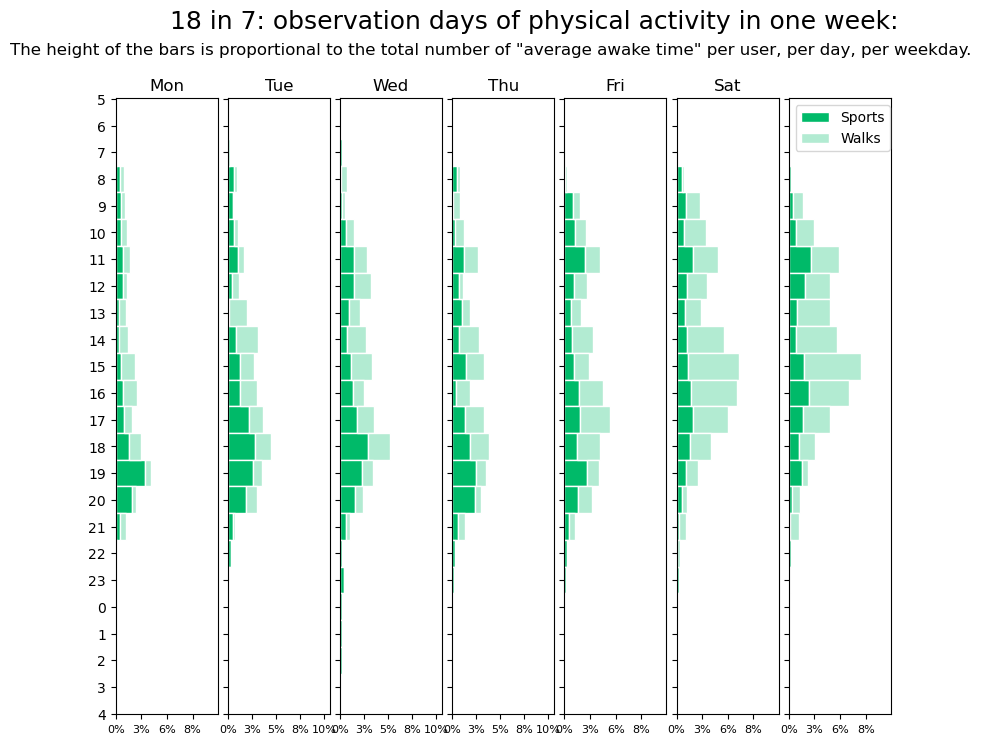

In [29]:
#For every day of the experiment, make one histogram. 
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"]]
    ax1 = axs[current_day]
    ax1.hist(values,
             bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
             stacked=True,edgecolor='white', label=['Sports', 'Walks'],
             color=("#00ba69", "#b2ebd2"),
             orientation = "horizontal")
    ax1.set_xticks([])
    N = g[g['hour'] == 0].shape[0]
    ax1.set_xlim([0, 0.11*N])
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))
    ax1.set_title(f'{weekdays[current_day]}')    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=8)
    ax1.invert_yaxis()
    ax1.margins(y=-0.02)
    
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    #.margins(y=-0.02)
    
    
fig.subplots_adjust(wspace=0.1)   
plt.suptitle('The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.', y=0.95)
plt.title("18 in 7: observation days of physical activity in one week:", fontsize=18, y=1.1 , x=-2.5)
plt.legend()
plt.savefig('a_typical_week.png')
plt.show()


# Sport time intervals and sex
In this section, the data visualization will split observations between sexes, always regarding sport sessions but changing control variables. 

In [30]:
#For every day of the experiment. Histogram instructions: 
'''
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == 'Inactive']]
    ax1 = axs[current_day]
    ax1.hist(values, 
               bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
               stacked=True,edgecolor='white', label=['Sports'],
               color=("#ff521b", "#ffef8a"),
               orientation = "horizontal")
    ax1.set_xticks([])
'''

#Violinplot instructions: 
'''
    # Extract relevant data for 'Sport' and 'Inactive'
    sport_data = g['hour'][g['what'] == 'Sport']
    inactive_data = g['hour'][g['what'] == 'Inactive']

    # Create a boxenplot using seaborn
    sns.violinplot(y=sport_data, color="#ff521b", ax=ax1, width=0.5)
'''
'''
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
demo = demo_dataset[[ 'userid', 'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN', 'w1_A10UNITN']]

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    ax1 = axs[current_day]
    
    # Extract relevant data for 'Sport' and 'Inactive'
    sport_data = g['hour'][g['what'] == 'Sport']
    inactive_data = g['hour'][g['what'] == 'Inactive']
    merged_df = g.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates()
    merged_df['id'] = merged_df['id'].astype(int)

    # Use sns.catplot with 'kind="violin"'
    sns.catplot(
        x='weekday',
        y='hour',
        hue='w1_A01',
        ax=ax1,
        data=merged_df[(merged_df['what'] == 'Sport') & (merged_df['weekday'] == weekdays[current_day])],
        kind='violin',
        split=True
    )
    
    ax1.grid(axis='x')
    ax1.invert_yaxis()
    ax1.set_title(f'{weekdays[current_day]}')    
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    else: 
        ax1.yaxis.set_visible(False)


fig.subplots_adjust(wspace=0.0)   
plt.suptitle('18 in 7: observation days of sport sessions in one week:', fontsize=18)
plt.text(0.5, 0.93, 'The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.',
         fontsize=12, ha='center', va='center', transform=fig.transFigure)
plt.savefig('violinplot_typicalweek.png')
plt.show()
'''
()

()

In [31]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
demo = demo_dataset[[ 'userid', 'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN', 'w1_A10UNITN']]

def which_day(t):
    return weekdays[t.weekday()]

def order_days(i):
    if i == 'Mon':
        return 0
    elif i == 'Tue':
        return 1
    elif i == 'Wed':
        return 2
    elif i == 'Thu':
        return 3
    elif i == 'Fri':
        return 4
    elif i == 'Sat':
        return 5
    elif i == 'Sun':
        return 6
    
    
results['weekday'] = results.date_not.apply(which_day)

csfont = {'fontname':'Times New Roman'}
hfont = {'fontname':'Helvetica'}

g = results
demo.userid = demo.userid.astype(int)
merged_df = g.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates().drop(columns="userid")
merged_df['id'] = merged_df['id'].astype(int)

merged_df['order'] = [order_days(i) for i in merged_df['weekday']]
merged_df = merged_df.sort_values(by='order')
sport_data = merged_df[merged_df['what'] == 'Sport']

F = demo.w1_A01.value_counts()[0]
M = demo.w1_A01.value_counts()[1]
N = F + M 
print(f'Generally speaking, if no participants dropped out, the Female to Male ratio in the dataset is:  {F}/{M} = {F/M:.2f}') 

F = demo[demo.userid.isin(sport_data.id.unique())].w1_A01.value_counts()[0]
M = demo[demo.userid.isin(sport_data.id.unique())].w1_A01.value_counts()[1]
print(f'Now, between the people who practiced sport at least once, the same ratio is: {F}/{M} = {F/M}')

/tmp/ipykernel_5924/3255247306.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo.userid = demo.userid.astype(int)


Generally speaking, if no participants dropped out, the Female to Male ratio in the dataset is:  142/107 = 1.33
Now, between the people who practiced sport at least once, the same ratio is: 70/56 = 1.25


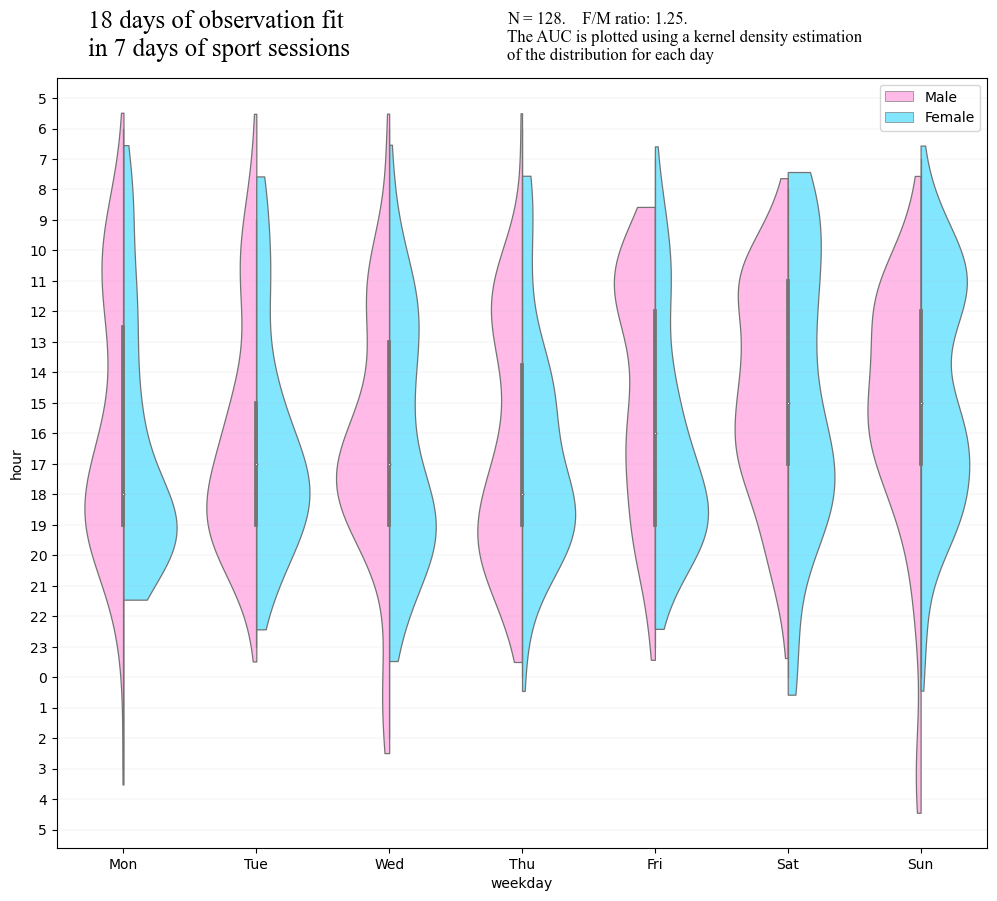

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
sns.violinplot(
    data=sport_data,  # Filter for 'Sport' sessions
    x="weekday",
    y="hour",
    hue="w1_A01",
    fill=False,
    split=True,
    palette=sns.color_palette(['#ffbae8', '#82e6ff']),
    #palette = sns.color_palette(['#00ba69']),
    dodge=True,
    linewidth=0.9,
    saturation=1,
    linecolor='#000000',
    legend=False,
    cut=0.3,
    label=['1', '2']
)
axs.invert_yaxis()
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.suptitle(f'18 days of observation fit \nin 7 days of sport sessions', 
             fontsize=18, y=0.948, x = 0.26, **csfont)
plt.text(0.5, 0.92, f'N = {len(sport_data.id.unique())}.    F/M ratio: {F/M}. \nThe AUC is plotted using a kernel density estimation \nof the distribution for each day',
         fontsize=12, ha='left', va='center', transform=fig.transFigure, **csfont)

plt.grid(axis='y', linewidth=0.1)
plt.legend()
plt.savefig('18daysinoneweek_gender.png')
plt.show()

In [33]:

stem = ['Natural Sciences', 'Medicine and veterinary medicine', 'Engineering and Applied Sciences', 'Agricultural', 'International Relations and Public Administration']
human = ['Law', 'Humanities']
soc_scien = ['Social Sciences', 'Business/economics']
print(len(sport_data.department.unique()), len(stem + human + soc_scien)) #nan is excluded

fields = []
for department in sport_data.department: 
    if department in stem: 
        fields.append('STEM')
    elif department in human: 
        fields.append('Humanities')
    elif department in soc_scien:
        fields.append('Social Sciences')
    else: 
        fields.append('nan')
sport_data['field'] = fields
sport_data.field.unique()

10 9


/tmp/ipykernel_5924/3253205446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sport_data['field'] = fields


array(['STEM', 'Social Sciences', 'Humanities', 'nan'], dtype=object)

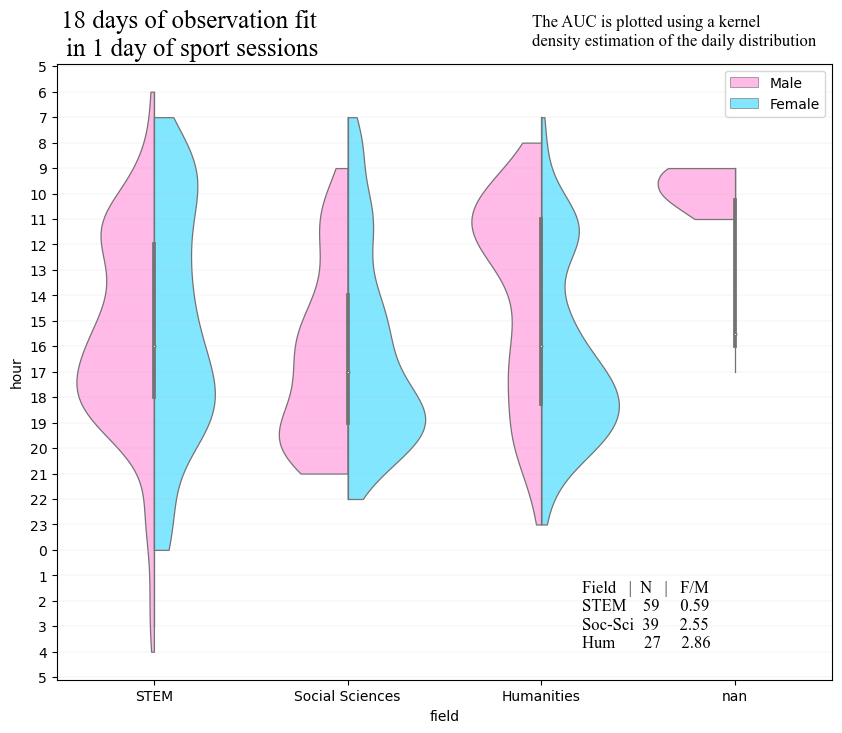

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.violinplot(
    data= sport_data,#.dropna(subset=['department']),
    x="field",
    y="hour",
    hue="w1_A01",
    fill=False,
    #split=True,
    palette=sns.color_palette(['#ffbae8', '#82e6ff']),
    dodge=True,
    split=True,
    linewidth=0.9,
    saturation=1,
    linecolor='#000000',
    legend=False,
    cut=0,
)
axs.invert_yaxis()
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.suptitle(f'18 days of observation fit \nin 1 day of sport sessions', 
             fontsize=18, y=0.948, x = 0.26, **csfont)

N = len(sport_data.id.unique())

Nstem = len(sport_data[(sport_data['field'] == 'STEM')].id.unique())
Nsocsci = len(sport_data[(sport_data['field'] == 'Social Sciences')].id.unique())
Nhum = len(sport_data[(sport_data['field'] == 'Humanities')].id.unique())

ids = sport_data[(sport_data['field'] == 'STEM')].id.unique()
NFstem = demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']
stem = NFstem / (Nstem - NFstem)

ids = sport_data[(sport_data['field'] == 'Social Sciences')].id.unique()
NFsocsci = demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']
soc_sci = NFsocsci / (Nsocsci - NFsocsci)

ids = sport_data[(sport_data['field'] == 'Humanities')].id.unique()
NFhum = demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']
hum = NFhum / (Nhum - NFhum)

plt.text(0.65, 0.19, f'\
Field   |  N   |   F/M \
\nSTEM    {Nstem}    {stem : .2f}\
\nSoc-Sci  {Nsocsci}    {soc_sci : .2f} \
\nHum       {Nhum}    {hum : .2f}',
         fontsize=12, ha='left', va='center', transform=fig.transFigure, **csfont)

plt.text(0.6, 0.92, f'The AUC is plotted using a kernel \ndensity estimation of the daily distribution',
         fontsize=12, ha='left', va='center', transform=fig.transFigure, **csfont)

plt.grid(axis='y', linewidth=0.1)
plt.legend()
plt.savefig('fieldandgender.png')
plt.show()

In [35]:
22/37

0.5945945945945946

In [36]:
ids = sport_data[(sport_data['field'] == 'Social Sciences')].id.unique()
demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']

28

In [38]:
import statistics
males = sport_data[sport_data.w1_A01 == 'Male']
females = sport_data[sport_data.w1_A01 == 'Female']

In [39]:
print(statistics.variance(females.hour))
print(statistics.median(females.hour))
print(statistics.mode(females.weekday))

15.0382721129689
12.0
Fri


In [40]:
print(statistics.variance(males.hour))
print(statistics.median(males.hour))
print(statistics.mode(males.weekday))

15.277165733223347
11.0
Sat


In [41]:
td_dataset[(td_dataset.first2w == "First two weeks") & td_dataset.id.isin(males.id) & (td_dataset.week == 'Friday') & (td_dataset.date_not.dt.hour > 13)].what.value_counts()


what
Study/work group                                  477
No information                                    427
Watching TV, video, YouTube, etc.                 315
Eating                                            238
Lecture/seminar/conference/university meeting     190
Social life                                       153
Did not do anything special                       148
Games                                             132
Expired                                           121
Sleeping                                          109
Rest/nap                                           88
Personal care                                      84
Cooking, Food preparation & management             73
Household and family care                          72
Sport                                              72
Travelling                                         63
Walking                                            52
Other                                              48
Reading a book, periodi

In [42]:
td_dataset[(td_dataset.first2w == "First two weeks") & td_dataset.id.isin(females.id) & (td_dataset.week == 'Friday') & (td_dataset.date_not.dt.hour > 13)].what.value_counts()

what
No information                                    657
Study/work group                                  645
Watching TV, video, YouTube, etc.                 422
Eating                                            284
Lecture/seminar/conference/university meeting     183
Did not do anything special                       161
Personal care                                     156
Social life                                       148
Expired                                           117
Rest/nap                                          115
Phone/Video calling                               113
Sleeping                                          111
Household and family care                         101
Social media (Facebook Instagram etc.)            100
Sport                                              92
Cooking, Food preparation & management             88
Walking                                            79
Games                                              61
Reading a book, periodi

In [43]:
td_dataset


,pilot,id,date_not,datein_ques,datein_answ,first2w,week,YY_not,MM_not,DD_not,...,c6_17,c6_18,c6_19,c6_20,c6_21,c6_22,c6_23,c6_24,c6_25,c6_26
0,wenetItaly,0.0,2020-11-13 00:00:00,2020-11-13 00:00:00,2020-11-13 00:00:00,First two weeks,Friday,2020.0,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wenetItaly,0.0,2020-11-13 00:30:00,2020-11-13 00:30:00,2020-11-13 00:30:00,First two weeks,Friday,2020.0,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,wenetItaly,0.0,2020-11-13 01:00:00,2020-11-13 01:00:00,2020-11-13 01:00:00,First two weeks,Friday,2020.0,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,wenetItaly,0.0,2020-11-13 01:30:00,2020-11-13 01:30:00,2020-11-13 01:30:00,First two weeks,Friday,2020.0,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,wenetItaly,0.0,2020-11-13 02:00:00,2020-11-13 02:00:00,2020-11-13 02:00:00,First two weeks,Friday,2020.0,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268469,wenetItaly,266.0,2020-12-11 19:00:00,2020-12-11 19:00:00,2020-12-11 21:38:15,Second two weeks,Friday,2020.0,12.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268470,wenetItaly,266.0,2020-12-11 20:00:00,2020-12-11 20:06:58,2020-12-11 21:38:24,Second two weeks,Friday,2020.0,12.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268471,wenetItaly,266.0,2020-12-11 21:00:00,2020-12-11 21:00:00,2020-12-11 21:38:37,Second two weeks,Friday,2020.0,12.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268472,wenetItaly,266.0,2020-12-11 22:00:00,2020-12-11 22:00:00,2020-12-12 00:14:37,Second two weeks,Friday,2020.0,12.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Some statistics. Predicting the hour of sport activity, and more

<Axes: >

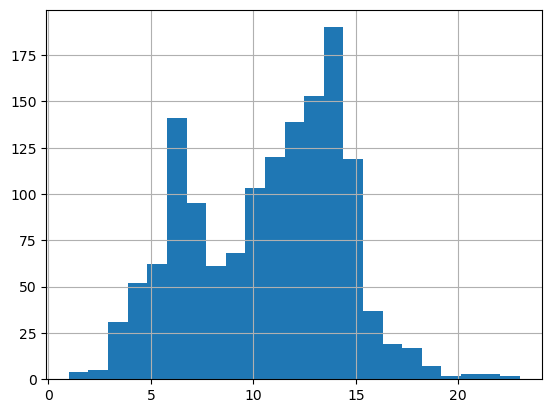

In [44]:
sport_data.hour.hist(bins=23)

In [45]:
# This data processing is solely for exploratory quick analyses on R (where decision trees classifiers
# are what I know best than scikit's decision trees)

merged_data = results.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates().drop(columns="userid")
merged_data['id'] = merged_data['id'].astype(int)
working_data = merged_data[['what','id', 'date_not', 'withw', 'where', 'day', 'weekday',
       'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN',
       'w1_A10UNITN']]

'''
to_drop = ["Expired", "I have a work/study meeting", "I am at the cinema/theater/hospital/church", "I will participate in sports activities", "Other","Others"]

for string in to_drop: 
    working_data['what'] = working_data['what'].replace(f'{string}', 'No Information')

working_data['what'] = working_data['what'].replace(["Arts", "Movie Theatre Concert ...", 
                                                     "Entertainment Exhibit, and Culture", 
                                                     "Others Entertainment and Culture"], "Hobbies")

'''


working_data['hour'] = working_data.date_not.dt.hour

working_data['withw'] = working_data['withw'].astype(str)
working_data['withw'] = working_data['withw'].replace('nan', 'No information')

working_data['where'] = working_data['where'].astype(str)
working_data['where'] = working_data['where'].replace('nan', 'No information')

working_data = working_data[working_data.id.isin(sport_data.id.unique())]
working_data = working_data.drop(['id', 'date_not', 'day'], axis='columns')

#working_data['what'] = working_data['what'] == 'Sport'
#working_data['what'] = working_data['what'].replace([True, False], ['Active', 'Inactive'])

to_recode = [el for el in working_data.w1_A10UNITN.unique()]

working_data['w1_A10UNITN'] = working_data['w1_A10UNITN'].replace(to_recode, ['Trento South',np.nan,
                                                                              'Center', 'North of Gardolo',
                                                                              'Piedicastello/Vela',
                                                                              'Mattarello/Ravina/Romagnano',
                                                                              'Trento North', 'Argentario/Marzola',
                                                                              'Argentario/Marzola',
                                                                              'Bondone'])

stem = ['Natural Sciences', 'Medicine and veterinary medicine', 'Engineering and Applied Sciences', 'Agricultural', 'International Relations and Public Administration']
human = ['Law', 'Humanities']
soc_scien = ['Social Sciences', 'Business/economics']
fields = []
for department in working_data.department: 
    if department in stem: 
        fields.append('STEM')
    elif department in human: 
        fields.append('Humanities')
    elif department in soc_scien:
        fields.append('Social Sciences')
    else: 
        fields.append('nan')

working_data = working_data[working_data['what'] == 'Sport']
working_data.to_csv('R analysis/WeNeteventsdata.csv')

# I went on R to conduct some basic analysis.
The goal was to check which categories from which variables seem to divide better the data regarding the weekday of sport. The unpruned tree for sport data is in decision_tree_plot_weekday.pdf. It is unreadable but you can zoom in. These basic results will be checked with visualization. 

In [293]:
!pip install pillow

In [325]:
from matplotlib.animation import FuncAnimation
from itertools import repeat
from PIL import Image
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import itertools
%matplotlib notebook

/tmp/ipykernel_5924/668346636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data['where'] = working_data['where'].replace(['Home apartment /room','Relatives Home',
/tmp/ipykernel_5924/668346636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data['where'] = working_data['where'].replace(['Café, pub, bar', 'Another indoor place', 'Shops, shopping centres'],
/tmp/ipykernel_5924/668346636.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

<IPython.core.display.Javascript object>


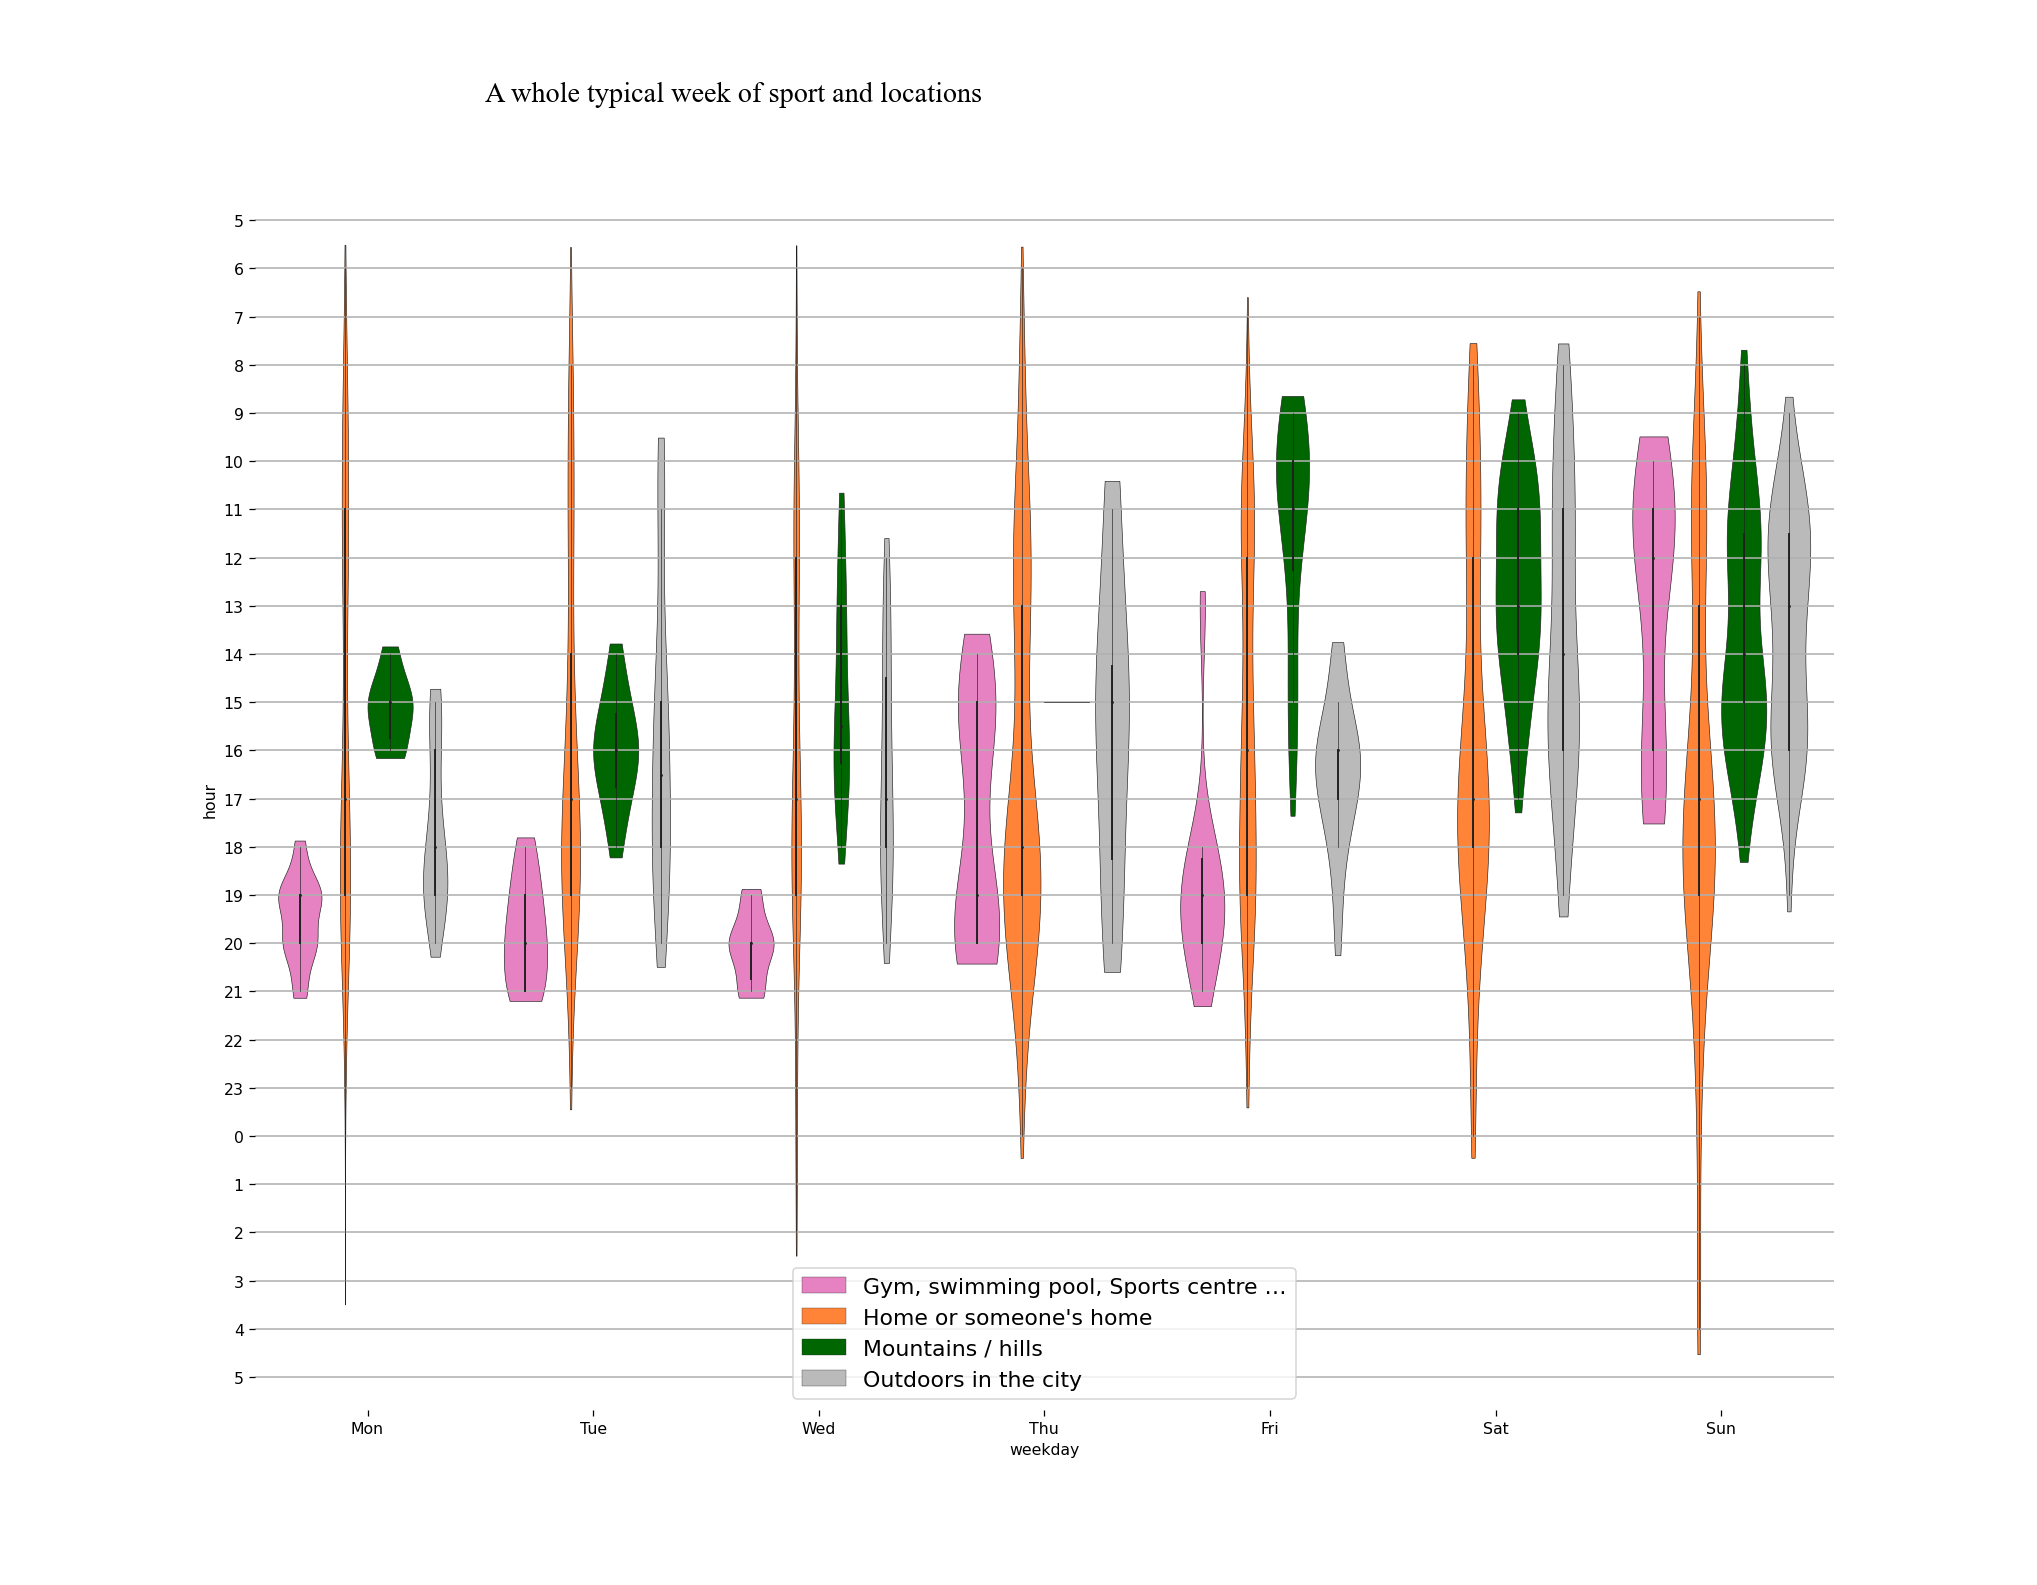

In [308]:
working_data = sport_data

working_data['where'] = working_data['where'].replace(['Home apartment /room','Relatives Home', 
                                                     'House (friends others)', 
                                                     'Home garden/patio/courtyard', 
                                                     'Weekend home or holiday apartment'], 
                                                    
                                                    'Home or someone\'s home')

working_data['where'] = working_data['where'].replace(['Café, pub, bar', 'Another indoor place', 'Shops, shopping centres'], 
                                                    'No information')

working_data['where'] = working_data['where'].replace('Countryside/mountain/hill/beach', 
                                                    'Mountains / hills')

working_data['where'] = working_data['where'].replace(['In the street', 'Another outdoor place'], 
                                                    'Outdoors in the city')
working_data['where'] = working_data['where'].replace(['Canteen',
                                                       'Other Library',
                                                       'Other university place',
                                                       'Grocery Shop',
                                                       'Supermarket …',
                                                       'Classroom/ Laboratory',
                                                       'Restaurant, pizzeria, Street food vendor',
                                                       'Movie Theatre Museum …',
                                                       'University Library',
                                                       'Classroom / Study hall',
                                                       'Workplace/office',
                                                       'Hotel, guesthouse, camping site',
                                                       'Travel',
                                                       'Not answer',
                                                       'Expired',
                                                       'Street markets'], 'Others')
working_data['where'] = working_data['where'].replace('Others', np.nan)
working_data['where'].value_counts()

fig, axs = plt.subplots(1, 1, figsize=(18, 14))
g = sns.violinplot(
        data=working_data,#[working_data.weekday == 'Mon'],
        x="weekday",
        y="hour",
        hue="where",
        fill=False,
        #split=True,
        palette=sns.color_palette(['#e681c2', '#ff8438', '#006602', '#bababa', '#82b5ba']),
        dodge=True,
        linewidth=0.4,
        saturation=1,
        linecolor='#000000',
        legend=False,
        cut=0.3,
)
axs.invert_yaxis()
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.suptitle(f'A whole typical week of sport and locations', 
             fontsize=18, y=0.948, x = 0.36, **csfont)
#plt.text(0.5, 0.92, f'{0}.',fontsize=12, ha='left', va='center', transform=fig.transFigure, **csfont)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.legend(loc='lower center', prop={'size': 14})
plt.grid(axis='y', linewidth=1)
plt.savefig('week_sport_andlocations.png', dpi = 500)
plt.show()

/tmp/ipykernel_5924/2503478535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdata['where'] = graphdata['where'].replace('No information', 'Home or someone\'s home')
/tmp/ipykernel_5924/2503478535.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdata['pub_pri'] = [pub_pri[cell] for cell in graphdata['where']]
/tmp/ipykernel_5924/2503478535.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

<IPython.core.display.Javascript object>


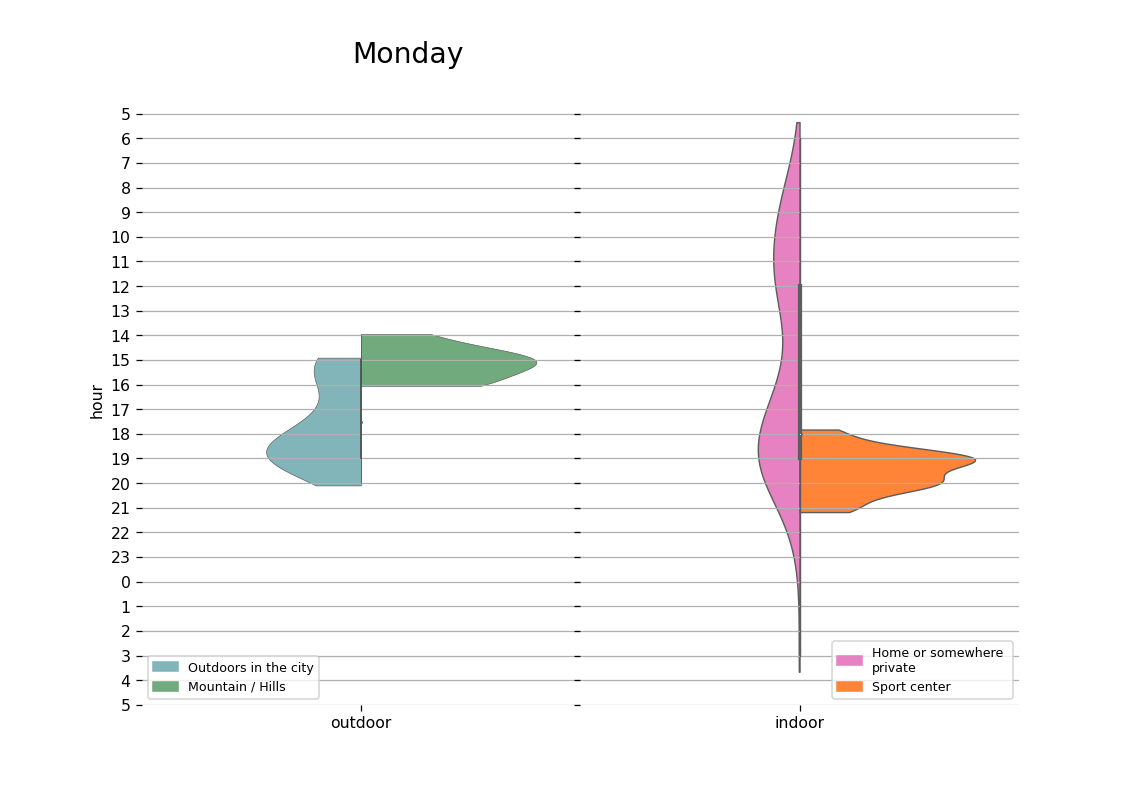

In [387]:
graphdata = working_data

graphdata['where'] = graphdata['where'].replace('No information', 'Home or someone\'s home')

pub_pri = {'Home or someone\'s home':'private', 'Outdoors in the city':'public', 
           'Gym, swimming pool, Sports centre …':'public', 'Mountains / hills':'private'}

out_ind = {'Home or someone\'s home':'indoor', 'Outdoors in the city':'outdoor', 
           'Gym, swimming pool, Sports centre …':'indoor', 'Mountains / hills':'outdoor'}

graphdata['pub_pri'] = [pub_pri[cell] for cell in graphdata['where']]
graphdata['out_ind'] = [out_ind[cell] for cell in graphdata['where']]
data = {
    'date_not': [np.nan]*2,
    'id': [np.nan]*2,
    'what': [np.nan]*2,
    'withw': [np.nan]*2,
    'where': [np.nan]*2,
    'day': [np.nan]*2,
    'hour': [12]*2,
    'weekday': ['Sat', 'Sun'],
    'w1_A01': [np.nan]*2,
    'department': [np.nan]*2,
    'degree': [np.nan]*2,
    'w1_A04UNITN': [np.nan]*2,
    'w1_A09UNITN': [np.nan]*2,
    'w1_A10UNITN': [np.nan]*2,
    'order': [np.nan]*2,
    'field': [np.nan]*2,
    'pub_pri': ['public', 'public'],
    'out_ind': ['indoor', 'indoor']
}
graphdata = pd.concat([graphdata, pd.DataFrame(data)], ignore_index=True)

grey_patch = mpatches.Patch(color=mcolors.hex2color('#82b5ba'))
green_patch = mpatches.Patch(color = mcolors.hex2color('#71ab7d'))
pink_patch = mpatches.Patch(color=mcolors.hex2color('#e681c2'))
orange_patch = mpatches.Patch(color = mcolors.hex2color('#ff8438'))


fig, ax = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

def update(frame):
    ax[0].cla()
    ax[1].cla()
    
    # FIRST SECTION
    g1 = sns.violinplot(data=graphdata[(graphdata['weekday'] == frame[:3]) & 
                                       (graphdata['out_ind'] == 'outdoor')],
                        x='out_ind', y='hour',
                        hue="pub_pri",
                        ax=ax[0],
                        split=True,
                        dodge=True,
                        linewidth=0.4,
                        saturation=1,
                        cut=0.1,
                        palette=sns.color_palette(['#82b5ba', '#71ab7d']),
                        linecolor='#000000')
    ax[0].set_yticks(np.arange(len(custom_order)))
    ax[0].set_yticklabels(custom_order)
    ax[0].invert_yaxis()
    ax[0].grid(axis='y')
    ax[0].set_xlabel('')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)

    ax[0].legend([grey_patch, green_patch], ['Outdoors in the city', 'Mountain / Hills'],
                 loc='lower left', prop={'size': 8})

    # SECOND SECTION
    g2 = sns.violinplot(data=graphdata[(graphdata['weekday'] == frame[:3]) & 
                                       (graphdata['out_ind'] == 'indoor')],
                        x='out_ind', y='hour',
                        hue="pub_pri",
                        ax=ax[1],
                        split=True,
                        dodge=True,
                        linewidth=0.9,
                        cut=0.4,
                        saturation=1,
                        palette=sns.color_palette(['#e681c2', '#ff8438']),
                        linecolor='#000000')

    ax[1].set_yticks(np.arange(len(custom_order)))
    ax[1].set_yticklabels(custom_order)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].grid(axis='y')
    ax[1].legend([pink_patch, orange_patch], ['Home or somewhere \nprivate', 'Sport center'],
                 loc='lower right', prop={'size': 8})
    
    plt.suptitle(f'{frame}',
                 fontsize=18, y=0.948, x=0.36)
    fig.subplots_adjust(wspace=-0.0001)



animation = FuncAnimation(fig, update, frames=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                          interval=1500)
name = 'everyday_location_activity.gif'
animation.save(name, writer='imagemagick', fps=0.5)

plt.show()

In [383]:
test = working_data

test['where'] = test['where'].replace('No information', 'Home or someone\'s home')

pub_pri = {'Home or someone\'s home':'private', 'Outdoors in the city':'public', 
           'Gym, swimming pool, Sports centre …':'public', 'Mountains / hills':'private'}

out_ind = {'Home or someone\'s home':'indoor', 'Outdoors in the city':'outdoor', 
           'Gym, swimming pool, Sports centre …':'indoor', 'Mountains / hills':'outdoor'}

test['pub_pri'] = [pub_pri[cell] for cell in test['where']]
test['out_ind'] = [out_ind[cell] for cell in test['where']]

data = {
    'date_not': [np.nan]*2,
    'id': [np.nan]*2,
    'what': [np.nan]*2,
    'withw': [np.nan]*2,
    'where': [np.nan]*2,
    'day': [np.nan]*2,
    'hour': [12]*2,
    'weekday': ['Sat', 'Sun'],
    'w1_A01': [np.nan]*2,
    'department': [np.nan]*2,
    'degree': [np.nan]*2,
    'w1_A04UNITN': [np.nan]*2,
    'w1_A09UNITN': [np.nan]*2,
    'w1_A10UNITN': [np.nan]*2,
    'order': [np.nan]*2,
    'field': [np.nan]*2,
    'pub_pri': ['public', 'public'],
    'out_ind': ['indoor', 'indoor']
}
test = pd.concat([test, pd.DataFrame(data)], ignore_index=True)

/tmp/ipykernel_5924/3185285974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['where'] = test['where'].replace('No information', 'Home or someone\'s home')
/tmp/ipykernel_5924/3185285974.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pub_pri'] = [pub_pri[cell] for cell in test['where']]
/tmp/ipykernel_5924/3185285974.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

<IPython.core.display.Javascript object>


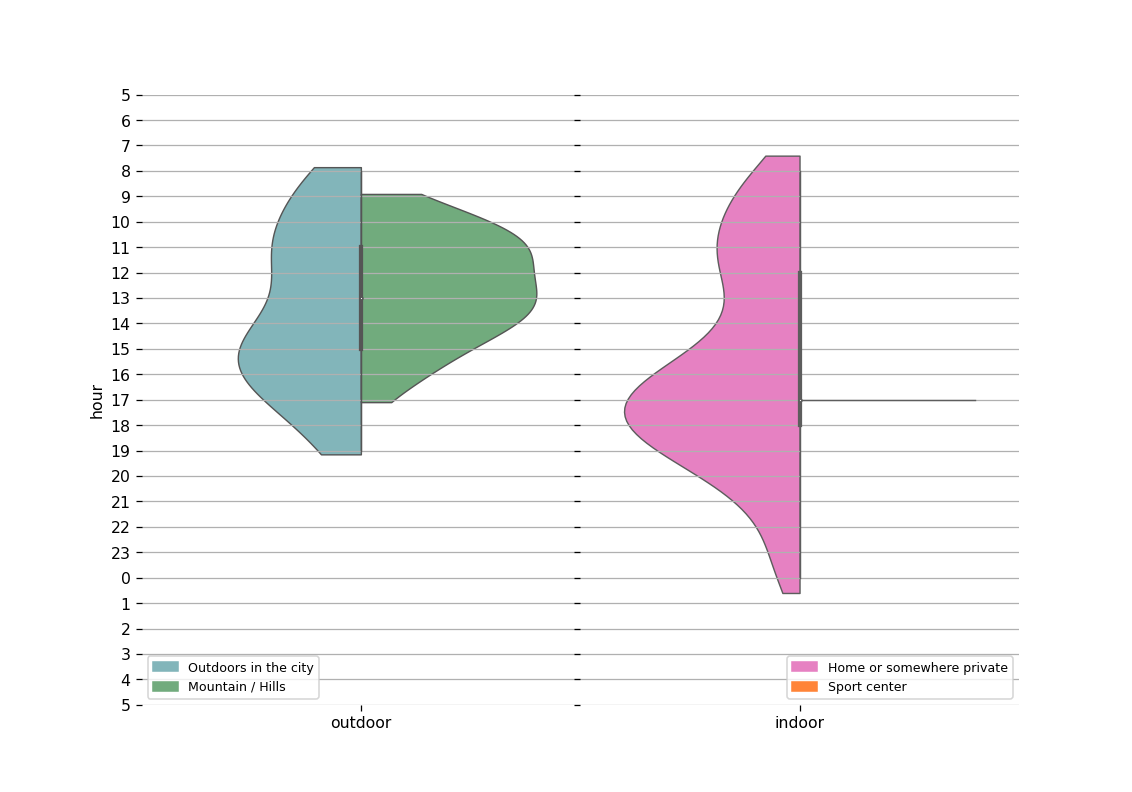

In [384]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

frame = 'Saturday'


g1 = sns.violinplot(data = test[(test['weekday'] == frame[:3]) & 
                                (test['out_ind'] == 'outdoor')], 
                    x='out_ind', y='hour', 
                    hue="pub_pri", 
                    ax=ax[0],
                    split=True,
                    dodge=True,
                    linewidth=0.9,
                    saturation=1,
                    cut = 0.1,
                    palette = sns.color_palette(['#82b5ba', '#71ab7d']),
                    #palette= sns.color_palette(['', '', '#006602'])
                    linecolor='#000000')
ax[0].set_yticks(np.arange(len(custom_order)))
ax[0].set_yticklabels(custom_order)
ax[0].invert_yaxis()
ax[0].grid(axis='y')
ax[0].set_xlabel('')
grey_patch = mpatches.Patch(color=mcolors.hex2color('#82b5ba'))
green_patch = mpatches.Patch(color = mcolors.hex2color('#71ab7d'))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[0].legend([grey_patch, green_patch], ['Outdoors in the city', 'Mountain / Hills'], 
             loc = 'lower left', prop={'size': 8})

#legend = ax[0].legend(['Outdoors in the city', 'Mountain / Hills'])



g2 = sns.violinplot(data = test[(test['weekday'] == frame[:3]) & 
                                (test['out_ind'] == 'indoor')], 
                    x='out_ind', y='hour', 
                    hue="pub_pri", 
                    ax=ax[1],
                    split=True,
                    dodge=True,
                    linewidth=0.9,
                    cut = 0.4,
                    saturation=1,
                    palette = sns.color_palette(['#e681c2', '#ff8438']),
                    linecolor='#000000')


ax[1].set_yticks(np.arange(len(custom_order)))
ax[1].set_yticklabels(custom_order)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].grid(axis='y')

grey_patch = mpatches.Patch(color=mcolors.hex2color('#e681c2'))
green_patch = mpatches.Patch(color = mcolors.hex2color('#ff8438'))


ax[1].legend([grey_patch, green_patch], ['Home or somewhere private', 'Sport center'], 
             loc = 'lower right', prop={'size': 8})

fig.subplots_adjust(wspace=-0.0001) 
#plt.tight_layout()
plt.show()

In [77]:
test[['where', 'pub_pri', 'out_ind']]

,where,pub_pri,out_ind
89116,Home or someone's home,private,indoor
89118,Home or someone's home,private,indoor
89121,Home or someone's home,private,indoor
86522,Home or someone's home,private,indoor
95134,Home or someone's home,private,indoor
...,...,...,...
179952,Outdoors in the city,public,outdoor
179934,Mountains / hills,private,outdoor
179937,Outdoors in the city,public,outdoor
179938,Outdoors in the city,public,outdoor


In [74]:
results

,date_not,id,what,withw,where,day,hour,weekday
0,2020-11-30 10:30:00,0.0,Inactive,NaN,NaN,18,5,Mon
1,2020-11-30 11:30:00,0.0,Inactive,NaN,NaN,18,6,Mon
2,2020-11-30 12:30:00,0.0,Inactive,NaN,NaN,18,7,Mon
3,2020-11-30 13:30:00,0.0,Inactive,NaN,NaN,18,8,Mon
4,2020-11-30 14:30:00,0.0,Inactive,NaN,NaN,18,9,Mon
...,...,...,...,...,...,...,...,...
208219,2020-11-13 15:00:00,266.0,Sleeping,Alone,Home apartment /room,1,10,Fri
208220,2020-11-13 14:30:00,266.0,Sleeping,Alone,Home apartment /room,1,9,Fri
208221,2020-11-13 14:00:00,266.0,Sleeping,Alone,Home apartment /room,1,9,Fri
208222,2020-11-13 13:30:00,266.0,Sleeping,Alone,Home apartment /room,1,8,Fri


ValueError: There must be exactly two hue levels to use `split`.'

In [378]:
frame='Sunday'

indoor_data = test[(test['weekday'] == frame[:3]) & (test['out_ind'] == 'indoor')]

data = {
    'date_not': [np.nan]*2,
    'id': [np.nan]*2,
    'what': [np.nan]*2,
    'withw': [np.nan]*2,
    'where': [np.nan]*2,
    'day': [np.nan]*2,
    'hour': [0]*2,
    'weekday': ['Sat', 'Sun'],
    'w1_A01': [np.nan]*2,
    'department': [np.nan]*2,
    'degree': [np.nan]*2,
    'w1_A04UNITN': [np.nan]*2,
    'w1_A09UNITN': [np.nan]*2,
    'w1_A10UNITN': [np.nan]*2,
    'order': [np.nan]*2,
    'field': [np.nan]*2,
    'pub_pri': ['public', 'public'],
    'out_ind': ['indoor', 'indoor']
}
indoor_data = pd.concat([indoor_data, pd.DataFrame(data)], ignore_index=True)



sns.violinplot(data = indoor_data[(indoor_data['weekday'] == frame[:3]) & 
                                (indoor_data['out_ind'] == 'indoor')], 
               x='out_ind', y='hour', 
               hue="pub_pri", 
               ax=ax[1],
               split=True,
               dodge=True,
               linewidth=0.9,
               cut = 0.4,
               saturation=1,
               palette = sns.color_palette(['#e681c2', '#ff8438']),
               linecolor='#000000')
indoor_data.pub_pri.unique()

array(['private', 'public'], dtype=object)

In [58]:
results.columns

Index(['date_not', 'id', 'what', 'withw', 'where', 'day', 'hour', 'weekday'], dtype='object')

In [72]:
IDs= pd.array(results.id.unique())
# maja_id is the list of all the users who did sport once
maja_id = pd.array([0, 1, 2, 4, 5, 6, 9, 10, 12, 15, 17, 19, 21, 22, 23, 24, 26, 27, 31, 32, 33, 37, 41, 43, 44, 45, 48, 53, 57, 58, 60, 61, 63, 66, 67, 68, 72, 73, 74, 75, 76, 77, 80, 82, 83, 84, 85, 87, 89, 92, 95, 97, 98, 99, 100, 103, 105, 106, 109, 112, 113, 114, 118, 119, 120, 123, 125, 127, 128, 130, 131, 134, 136, 137, 141, 146, 148, 149, 151, 153, 155, 160, 163, 164, 167, 169, 172, 177, 182, 185, 190, 199, 202, 204, 205, 206, 207, 213, 214, 215, 216, 218, 219, 220, 222, 223, 227, 228, 229, 231, 232, 233, 238, 239, 240, 242, 243, 244, 245, 250, 251, 254, 255, 256, 258, 260, 262, 265, 266])
IDs = IDs[IDs.isin(maja_id)]
user_activity = dict()
for ID in tqdm(IDs):
    
    id_act = results[results.id == ID]
    # adding to the dictionary
    user_activity[f'{ID}'] = pd.Series(id_act.day.unique()).sort_values()

print('N:',len(user_activity.keys())) 
print("Done!")


100%|███████████████████████████████████████| 129/129 [00:00<00:00, 2131.24it/s]

N: 129
Done!


In [75]:
def gantt_data_org(k, v):
    
    #gantt data is named after the Gantt chart, although it's not present here
    #S is the Series of days; it's best if it's a consecutive 14 days (regardless of when they start)
    
    tot = 0
    start = np.nan
    end = np.nan
    consecutive = False
    
    if len(v):  #if it's not empty, it will check for continuity
        tot = (pd.to_datetime(v[-1]) - pd.to_datetime(v[0])).days
        start, end = v[0], v[-1]
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            if difference >= 2:    # if there is more than one day of difference it means that there was one 
                                   # day in the data with no observations
                consecutive = False
                break
            else:
                consecutive = True
                
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['userid', 'start', 'finish', 'tot', 'cons'])

#example of output:
gantt_data_org(1, ["2020-11-12", "2020-11-13", "2020-11-14", "2020-11-15", "2020-11-16", 
                   "2020-11-17",   "2020-11-18", "2020-11-19", "2020-11-25"])
gantt_data = pd.DataFrame(columns=["id", "start", "finish", "tot", "cons"])


for ID, days in user_activity.items():
    res = gantt_data_org(ID, days.tolist())
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)

maja_id = set(maja_id)
consecutive_id = set(gantt_data.userid)
len(maja_id - consecutive_id)

129

In [95]:
len(consecutive_id - maja_id)

129